### FINBERT

In [3]:
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
import nltk
from nltk.corpus import stopwords

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거

#### Data Import 

In [12]:
speech = pd.read_excel('../../Data/speech_df.xlsx', index_col = 1)

In [13]:
speech

,Unnamed: 0,title,speaker,speech
date,,,,
"November 16, 2023",0,"Global Linkages: Supply, Spillovers, and Comm...",Governor Lisa D. Cook,"Thank you, Sylvain, and thank you for the opp..."
"November 16, 2023",1,The 2023 U.S. Treasury Market Conference,Vice Chair for Supervision Michael S. Barr,I am pleased to join you today at the ninth a...
"November 14, 2023",2,Elevated Economic Uncertainty: Causes and Cons...,Vice Chair Philip N. Jefferson,Introduction \nThank you for the opportunity ...
"November 13, 2023",3,Welcoming Remarks,Governor Lisa D. Cook,"Good morning, and welcome to the 5th annual c..."
"November 09, 2023",4,Opening Remarks,Chair Jerome H. Powell,Thank you for the opportunity to participate ...
...,...,...,...,...
"February 24, 2006",1041,The Benefits of Price Stability,Chairman Ben S. Bernanke,It is a great pleasure for me to return to Pr...
"February 23, 2006",1042,"Globalization, Insurers, and Regulators: Share...","Vice Chairman Roger W. Ferguson, Jr.",I am honored to deliver the keynote address a...
"February 06, 2006",1043,Remarks at ceremonial swearing-in by President...,Chairman Ben S. Bernanke,Good morning. I would like to begin by thanki...


In [14]:
speech.index = pd.to_datetime(speech.index)

In [15]:
speech

,Unnamed: 0,title,speaker,speech
date,,,,
2023-11-16,0,"Global Linkages: Supply, Spillovers, and Comm...",Governor Lisa D. Cook,"Thank you, Sylvain, and thank you for the opp..."
2023-11-16,1,The 2023 U.S. Treasury Market Conference,Vice Chair for Supervision Michael S. Barr,I am pleased to join you today at the ninth a...
2023-11-14,2,Elevated Economic Uncertainty: Causes and Cons...,Vice Chair Philip N. Jefferson,Introduction \nThank you for the opportunity ...
2023-11-13,3,Welcoming Remarks,Governor Lisa D. Cook,"Good morning, and welcome to the 5th annual c..."
2023-11-09,4,Opening Remarks,Chair Jerome H. Powell,Thank you for the opportunity to participate ...
...,...,...,...,...
2006-02-24,1041,The Benefits of Price Stability,Chairman Ben S. Bernanke,It is a great pleasure for me to return to Pr...
2006-02-23,1042,"Globalization, Insurers, and Regulators: Share...","Vice Chairman Roger W. Ferguson, Jr.",I am honored to deliver the keynote address a...
2006-02-06,1043,Remarks at ceremonial swearing-in by President...,Chairman Ben S. Bernanke,Good morning. I would like to begin by thanki...


In [16]:
daily_sentiments = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])
unique_dates = speech.index.unique()
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
text_for_date = speech["speech"].tolist()

tokenized_texts = [
        [word for word in tokenizer.tokenize(text) if word.lower() not in stop_words]
        for text in text_for_date]

In [20]:
len(max(tokenized_texts, key = len))

4761

In [21]:
import time 
start_time = time.time()

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for date in unique_dates:    
    #text_for_date = data[data["rgs_dt"] == date]["news_smy_ifo"].tolist()
    text_for_date = speech[speech.index == date]["speech"].tolist()

    tokenized_texts = [
        [word for word in tokenizer.tokenize(text) if word.lower() not in stop_words]
        for text in text_for_date
    ]

    max_token_length = 150

    tokenized_texts = [" ".join(tokens[:max_token_length]) for tokens in tokenized_texts]
    inputs = tokenizer(tokenized_texts, padding = True, truncation = True, return_tensors = "pt", max_length = max_token_length)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    positive_prob = probabilities[:, 2].mean().item()
    negative_prob = probabilities[:, 0].mean().item()
    neutral_prob = probabilities[:, 1].mean().item()
    
    daily_sentiments = pd.concat([daily_sentiments, 
                                  pd.DataFrame({"Date": date, 
                                                "Positive": positive_prob, 
                                                "Negative": negative_prob, 
                                                "Neutral": neutral_prob}, index = ['0'])],
                                 ignore_index = True)

daily_sentiments.index = daily_sentiments.Date
daily_sentiments = daily_sentiments.iloc[:,1:]
daily_sentiments

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Positive,Negative,Neutral
Date,,,
2023-11-16,9.260676e-05,6.362590e-01,0.363648
2023-11-14,8.614503e-05,9.999092e-01,0.000005
2023-11-13,3.063124e-06,2.920278e-03,0.997077
2023-11-09,3.795873e-05,4.946647e-01,0.505297
2023-11-08,2.169078e-04,6.716564e-01,0.328127
...,...,...,...
2006-02-24,5.051418e-06,9.862870e-01,0.013708
2006-02-23,9.557231e-06,8.381755e-04,0.999152
2006-02-06,1.203636e-05,9.765797e-01,0.023408


In [22]:
daily_sentiments['sentimental_score'] = daily_sentiments['Positive'] - daily_sentiments['Negative'] + daily_sentiments['Neutral'] * 0.5

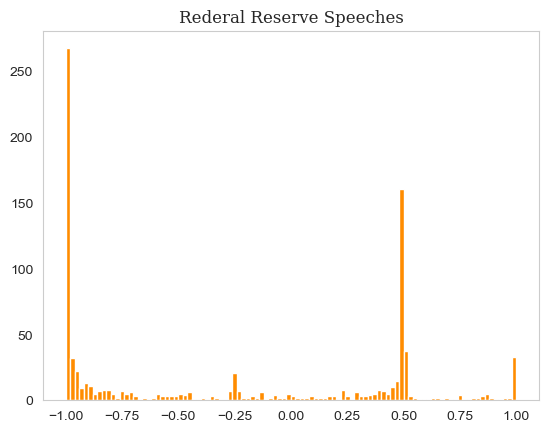

In [28]:
import matplotlib.pyplot as plt

plt.hist(daily_sentiments['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("Federal Reserve Speeches", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [35]:
daily_sentiments.resample('M').mean()

,Positive,Negative,Neutral,sentimental_score
Date,,,,
2006-01-31,7.971052e-08,2.516444e-07,1.000000,0.500000
2006-02-28,2.134020e-01,4.994306e-01,0.287167,-0.142445
2006-03-31,2.156177e-01,5.577889e-01,0.226593,-0.228875
2006-04-30,4.671889e-02,4.433666e-01,0.509914,-0.141691
2006-05-31,1.709526e-04,6.226610e-01,0.377168,-0.433906
...,...,...,...,...
2023-07-31,5.476058e-02,6.210716e-01,0.324168,-0.404227
2023-08-31,5.046593e-04,7.823840e-01,0.217111,-0.673324
2023-09-30,1.012808e-03,6.145024e-01,0.384485,-0.421247


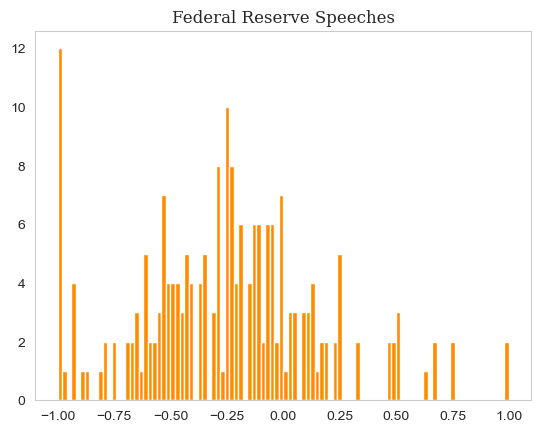

In [38]:
plt.hist(daily_sentiments.resample('M').mean()['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("Federal Reserve Speeches", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [37]:
# daily_sentiments.resample('M').mean().to_csv('../../Data/federal_sentiment.csv')

In [29]:
daily_sentiments_excerpt = pd.DataFrame(columns = ["Date", "Positive", "Negative", "Neutral"])

text_for_date = speech["title"].tolist()

tokenized_texts = [
        [word for word in tokenizer.tokenize(text) if word.lower() not in stop_words]
        for text in text_for_date]

start_time = time.time()

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

for date in unique_dates:    
    #text_for_date = data[data["rgs_dt"] == date]["news_smy_ifo"].tolist()
    text_for_date = speech[speech.index == date]["title"].tolist()

    tokenized_texts = [
        [word for word in tokenizer.tokenize(text) if word.lower() not in stop_words]
        for text in text_for_date
    ]

    max_token_length = 500

    tokenized_texts = [" ".join(tokens[:max_token_length]) for tokens in tokenized_texts]
    inputs = tokenizer(tokenized_texts, padding = True, truncation = True, return_tensors = "pt", max_length = max_token_length)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    probabilities = torch.softmax(logits, dim=1)
    positive_prob = probabilities[:, 2].mean().item()
    negative_prob = probabilities[:, 0].mean().item()
    neutral_prob = probabilities[:, 1].mean().item()
    
    daily_sentiments_excerpt = pd.concat([daily_sentiments_excerpt, 
                                          pd.DataFrame({"Date": date, 
                                                        "Positive": positive_prob, 
                                                        "Negative": negative_prob, 
                                                        "Neutral": neutral_prob}, index = ['0'])],
                                 ignore_index = True)

daily_sentiments_excerpt.index = daily_sentiments_excerpt.Date
daily_sentiments_excerpt = daily_sentiments_excerpt.iloc[:,1:]
daily_sentiments_excerpt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/junghunlee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Positive,Negative,Neutral
Date,,,
2023-11-16,0.000021,9.996207e-01,3.580711e-04
2023-11-14,0.999999,2.141863e-07,7.070903e-07
2023-11-13,0.000006,9.999937e-01,1.253463e-07
2023-11-09,0.000040,9.999586e-01,1.023317e-06
2023-11-08,0.000435,6.662204e-01,3.333444e-01
...,...,...,...
2006-02-24,0.001206,4.980852e-01,5.007090e-01
2006-02-23,0.000487,9.849166e-01,1.459588e-02
2006-02-06,0.000006,9.999704e-01,2.320365e-05


In [30]:
daily_sentiments_excerpt['sentimental_score'] = daily_sentiments_excerpt['Positive'] - daily_sentiments_excerpt['Negative'] + daily_sentiments_excerpt['Neutral'] * 0.5

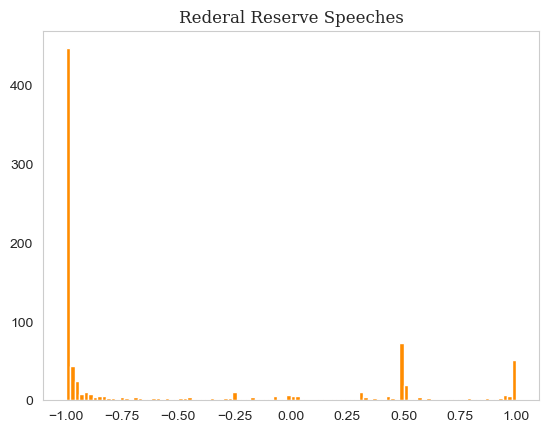

In [31]:
import matplotlib.pyplot as plt

plt.hist(daily_sentiments_excerpt['sentimental_score'], bins = 100, color = 'darkorange')
plt.grid(False)
plt.title("Rederal Reserve Speeches", fontsize = 12, fontfamily = 'Serif')
plt.show()